# Installation

In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     |████████████████████████████████| 7.9 MB 25.8 MB/s 
     |████████████████████████████████| 3.5 MB 27.7 MB/s 
     |████████████████████████████████| 407 kB 32.0 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 


# Helper Fns

In [2]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

> Using KarateCub dataset

In [3]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [4]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [5]:
data

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])

In [6]:
data.y

tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])

In [7]:
data.train_mask

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])

In [10]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

> The edge index is in COO(**coordinate format**), where first value is source noe index, and second is destimation node index

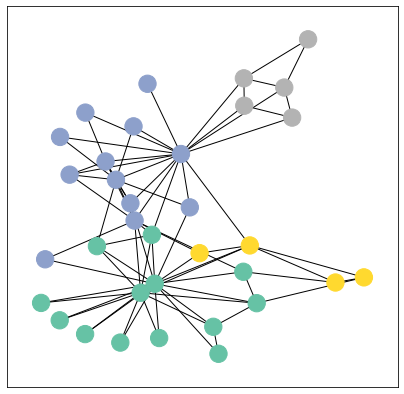

In [11]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

# Designing the Model

> We will follow simple **neural message passing scheme**, where node features **$\mathbf{x}_v^{(\ell)}$** of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating localized information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$

In [12]:
# Now we will use simplest GNN operator GCN layer, which is defined as

> $$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

In [13]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    torch.manual_seed(12)
    self.conv1=GCNConv(dataset.num_features, 4)
    self.conv2=GCNConv(4,4)
    self.conv3=GCNConv(4,2)
    self.classifier=Linear(2, dataset.num_classes)

  def forward(self, x, edge_index):

    h=self.conv1(x, edge_index)
    h=h.tanh()
    h=self.conv2(h, edge_index)
    h=h.tanh()
    h=self.conv3(h, edge_index)
    h= h.tanh()  # These are the embeddings

    out=self.classifier(h)

    return out, h                 


In [14]:
model=GCN()
model

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)

In [15]:
# Inspecting the putput from model
out, h=model(data.x, data.edge_index)
out.shape, h.shape

(torch.Size([34, 4]), torch.Size([34, 2]))

In [17]:
train_out=out[data.train_mask]
train_out.shape, data.y[data.train_mask]

(torch.Size([4, 4]), tensor([1, 3, 0, 2]))

In [18]:
train_out

tensor([[-0.8141,  0.2058, -0.6091,  0.6458],
        [-0.6813,  0.1844, -0.5231,  0.5922],
        [-0.6940,  0.1965, -0.5384,  0.6212],
        [-0.5425,  0.1866, -0.4505,  0.5946]], grad_fn=<IndexBackward0>)

In [19]:
import time
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model= GCN()
criterion= torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
  optimizer.zero_grad()
  out, h= model(data.x, data.edge_index)
  loss= criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()

  return loss, h


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

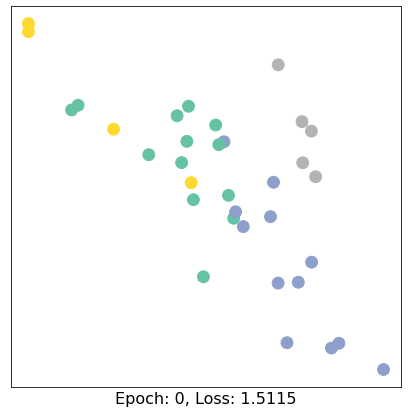

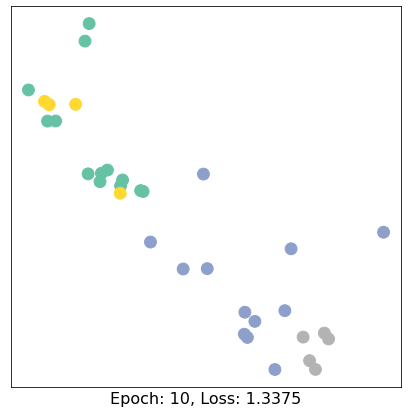

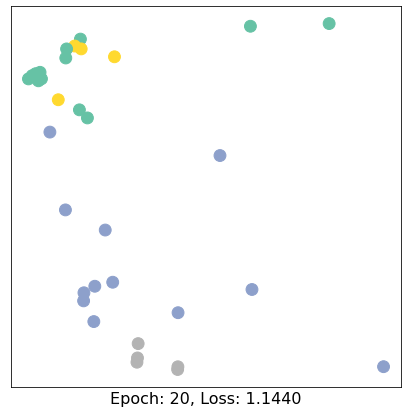

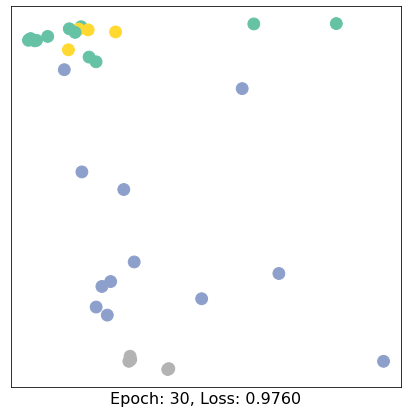

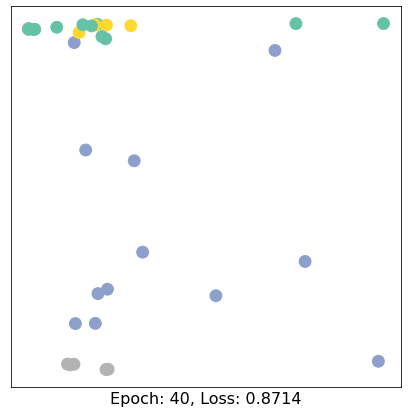

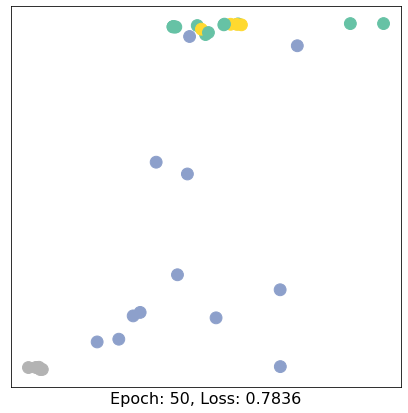

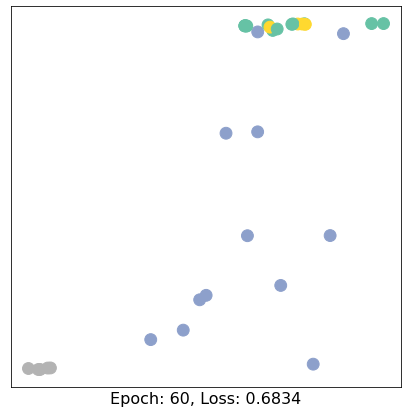

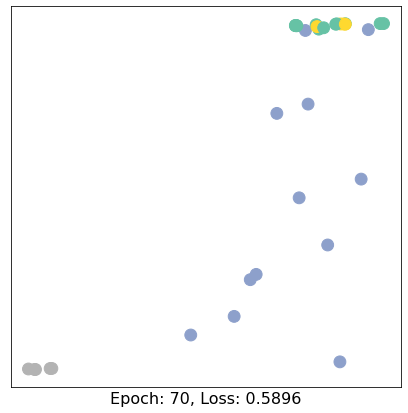

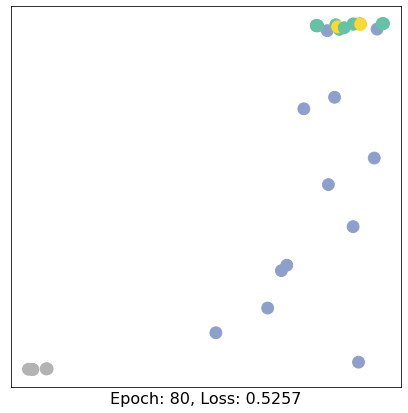

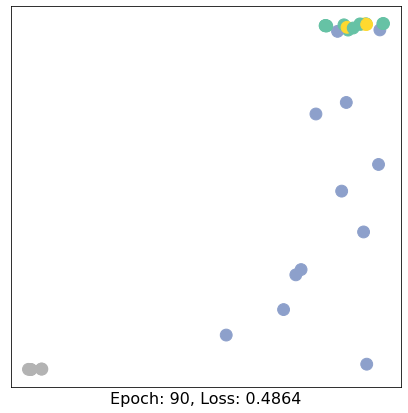

In [20]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

for epoch in range(100):
  loss, h= train(data)
  if epoch % 10 == 0:
    visualize_embedding(h, color= data.y, epoch=epoch, loss= loss)
    time.sleep(0.5)